In [ ]:
import pandas as pd


addr_tx = pd.read_csv('elliptic/AddrTx_edgelist.csv')
tx_addr = pd.read_csv('elliptic/TxAddr_edgelist.csv')
wallets = pd.read_csv('elliptic/wallets_classes.csv')
txs_features = pd.read_csv('elliptic/txs_features.csv')


tx_edges = pd.merge(addr_tx, tx_addr, on='txId', how='inner')
tx_edges = pd.merge(tx_edges, txs_features, on='txId', how='left')
tx_edges = pd.merge(tx_edges, wallets.rename(columns={'address': 'input_address', 'class': 'src_class'}),
                    on='input_address', how='left')
tx_edges = pd.merge(tx_edges, wallets.rename(columns={'address': 'output_address', 'class': 'dst_class'}),
                    on='output_address', how='left')

agg_edges = (
    tx_edges.groupby(['input_address', 'output_address', 'Time step', 'src_class', 'dst_class'])
    .size()
    .reset_index(name='weight')
)

agg_edges = agg_edges.rename(columns={
    'input_address': 'src_addr',
    'output_address': 'dst_addr',
    'Time step': 'time step'
})

agg_edges = agg_edges.sort_values(by='time step', ascending=True)
agg_edges.to_csv('elliptic/AddrAddr_timestep.csv', index=False)

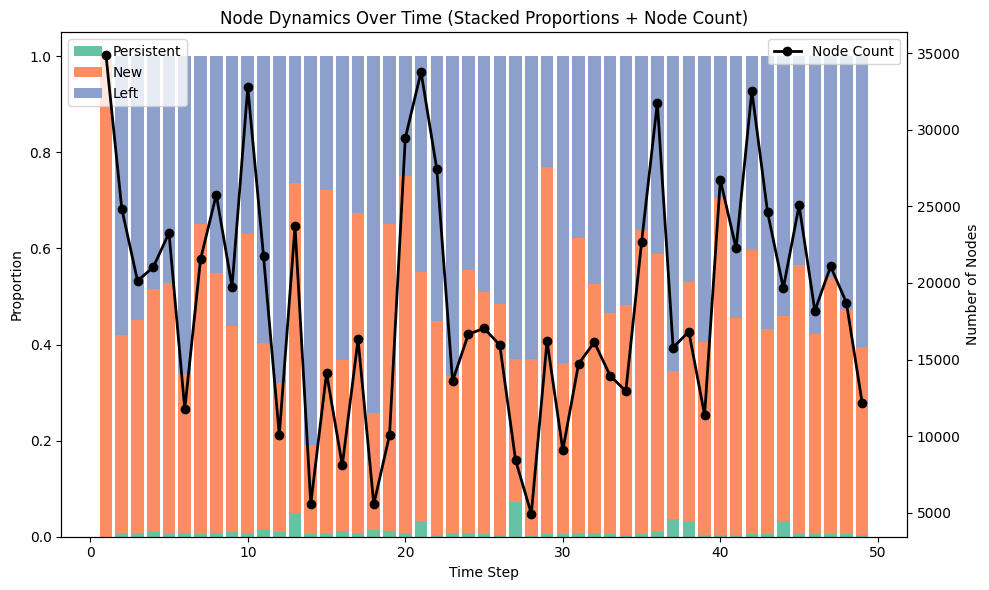

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取前面生成的文件
edges = pd.read_csv('elliptic/AddrAddr_timestep.csv')

# 1️⃣ 去除自环
edges = edges[edges['src_addr'] != edges['dst_addr']]

# 2️⃣ 获取每个时间步的节点集合
time_steps = sorted(edges['time step'].unique())
node_sets = {t: set(edges.loc[edges['time step'] == t, ['src_addr', 'dst_addr']].values.flatten())
             for t in time_steps}

# 3️⃣ 计算新增、离开、持续存在比例 + 节点总数
records = []
for i, t in enumerate(time_steps):
    current_nodes = node_sets[t]
    if i == 0:
        records.append({
            'time step': t,
            'new_nodes': 1.0,
            'left_nodes': 0.0,
            'persistent_nodes': 0.0,
            'num_nodes': len(current_nodes)
        })
    else:
        prev_nodes = node_sets[time_steps[i - 1]]
        new_nodes = current_nodes - prev_nodes
        left_nodes = prev_nodes - current_nodes
        persistent_nodes = current_nodes & prev_nodes
        total = len(current_nodes | prev_nodes)
        records.append({
            'time step': t,
            'new_nodes': len(new_nodes) / total if total > 0 else 0,
            'left_nodes': len(left_nodes) / total if total > 0 else 0,
            'persistent_nodes': len(persistent_nodes) / total if total > 0 else 0,
            'num_nodes': len(current_nodes)
        })

# 4️⃣ 转为DataFrame
df = pd.DataFrame(records)

# 5️⃣ 绘制堆叠柱状图 + 节点数量折线图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 堆叠柱状图
ax1.bar(df['time step'], df['persistent_nodes'], label='Persistent', color='#66c2a5')
ax1.bar(df['time step'], df['new_nodes'], bottom=df['persistent_nodes'], label='New', color='#fc8d62')
ax1.bar(df['time step'], df['left_nodes'],
        bottom=df['persistent_nodes'] + df['new_nodes'], label='Left', color='#8da0cb')

ax1.set_xlabel('Time Step')
ax1.set_ylabel('Proportion')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='upper left')

# 第二个y轴：节点总数折线
ax2 = ax1.twinx()
ax2.plot(df['time step'], df['num_nodes'], color='black', marker='o', linewidth=2, label='Node Count')
ax2.set_ylabel('Number of Nodes')
ax2.legend(loc='upper right')

plt.title('Node Dynamics Over Time (Stacked Proportions + Node Count)')
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

# 读取文件
df = pd.read_csv("elliptic/AddrAddr_timestep.csv")

# 去除自环
df = df[df['src_addr'] != df['dst_addr']]

# 选取并重命名列
df_out = df.rename(columns={
    'src_addr': 'u',
    'dst_addr': 'v',
    'time step': 'layer',
    'src_class': 'u_label',
    'dst_class': 'v_label'
})[['u', 'v', 'layer', 'u_label', 'v_label']]

df_out.to_csv("crypto.csv",index=None)
print(df_out.head())

                                    u                                   v  \
0  14xgrsbMeVnDZmCYxXEVu7V155ECvc27qo   1D12giTaEK9zVePUX9d5R5boQJpGZeLet   
1  1EpssaGpw5Gr8w1hSfSLEVJsZHN6RnLSYi  12KF66Q1hu6wT8DowG9f29kFwFgwpFtj1Q   
2  1EpssaGpw5Gr8w1hSfSLEVJsZHN6RnLSYi  1225bGfqMmYHsCCkAAHry5UXzAQjYvTbR6   
3  1Q5ryjxf5sHZgxn5Z3DTtq1NQ6iMACRNyg   1tv7TyixNVsM8kcNRj4idhxwfMuWbFtdW   
5  1EprKaHpan5gfQCKiLwiz5dyc1WQQCdYQL  1D5LcBfkhjdKQ8vVYSYjXaYTreQr22JR2B   

   layer  u_label  v_label  
0      1        3        3  
1      1        3        3  
2      1        3        3  
3      1        3        3  
5      1        3        3  


In [4]:
from algorithms import *

crypto_partition = infomap_communities("elliptic/crypto.csv","elliptic/community.csv",jsd_relax_rate=0.25)

/Users/peijiezhong/Desktop/research/multilayer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


results write to elliptic/community.csv.


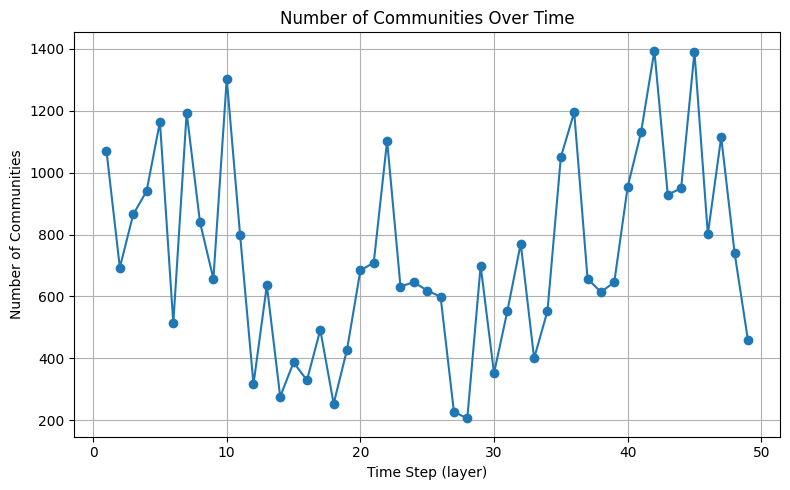

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取文件
df = pd.read_csv("elliptic/community.csv")

# 计算每个时间步的社区数量
community_counts = df.groupby('layer')['community'].nunique().reset_index()

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(community_counts['layer'], community_counts['community'], marker='o', linestyle='-')
plt.xlabel('Time Step (layer)')
plt.ylabel('Number of Communities')
plt.title('Number of Communities Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

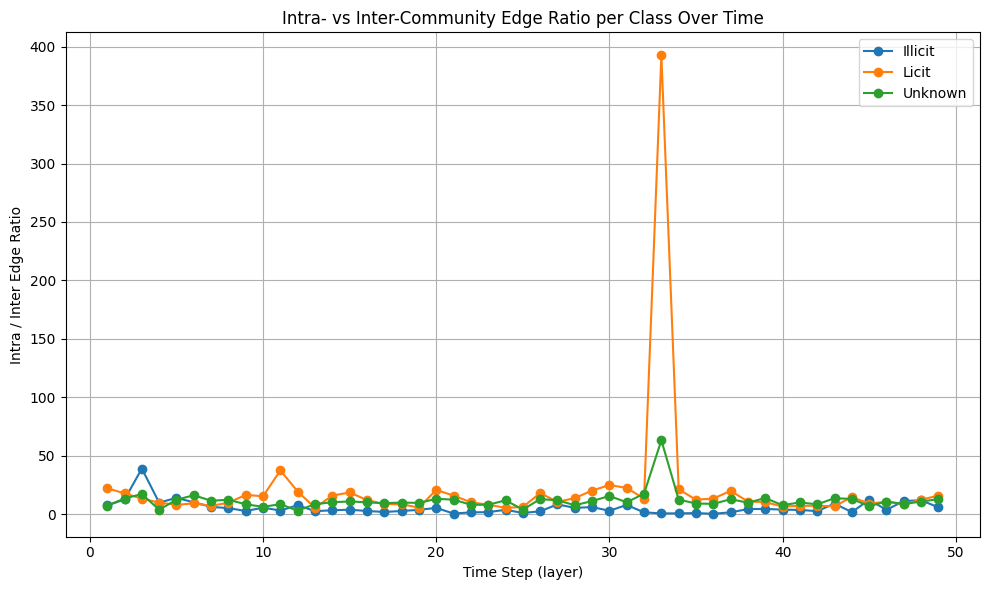

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取数据 ===
edges = pd.read_csv("elliptic/AddrAddr_timestep.csv")
communities = pd.read_csv("elliptic/community.csv")

# === 2. 建立节点到社区的映射 ===
node2comm = communities.set_index(['node_id', 'layer'])['community']

# === 3. 给边两端加上社区编号 ===
edges['src_community'] = edges.apply(
    lambda row: node2comm.get((row['src_addr'], row['time step']), None), axis=1
)
edges['dst_community'] = edges.apply(
    lambda row: node2comm.get((row['dst_addr'], row['time step']), None), axis=1
)

# 去掉无法匹配社区的边
edges = edges.dropna(subset=['src_community', 'dst_community'])

# === 4. 判断边类型：社区内部 / 社区之间 ===
edges['edge_type'] = edges.apply(
    lambda row: 'intra' if row['src_community'] == row['dst_community'] else 'inter', axis=1
)

# === 5. 统计每个时间步、节点类型的内部/之间边数量 ===
stats = edges.groupby(['time step', 'src_class', 'edge_type']).size().reset_index(name='count')

# === 6. 转换为透视表 ===
pivot = stats.pivot_table(
    index=['time step', 'src_class'], columns='edge_type', values='count', fill_value=0
).reset_index()

# === 7. 计算比例 intra/inter ===
pivot['ratio'] = pivot['intra'] / (pivot['inter'].replace(0, pd.NA))  # 防止除0
pivot = pivot.dropna(subset=['ratio'])

# === 8. 绘制折线图 ===
plt.figure(figsize=(10, 6))
for c, label in zip([1, 2, 3], ['Illicit', 'Licit', 'Unknown']):
    sub = pivot[pivot['src_class'] == c]
    plt.plot(sub['time step'], sub['ratio'], marker='o', label=label)

plt.xlabel('Time Step (layer)')
plt.ylabel('Intra / Inter Edge Ratio')
plt.title('Intra- vs Inter-Community Edge Ratio per Class Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()